In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from statsmodels.api import GLS, WLS, add_constant
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
import warnings

# Suppress FutureWarnings globally
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to calculate streamflow based on P, PET, and n
def calculate_streamflow(P, PET, n):
    return P - (P**-n + PET**-n)**(-1 / n)

# Function to calculate sensitivities dQ/dP and dQ/dPET
def calculate_sensitivities(P, PET, n):
    dQ_dP = 1 - (1 + (P / PET)**n)**((-1 / n) - 1)
    dQ_dPET = - (1 + (PET / P)**n)**((-1 / n) - 1)
    return dQ_dP, dQ_dPET

np.random.seed(123)

# METHODS:
# For comparison only: 
# Nonparam., Single Reg.
# For actual analysis: 
# Mult. Reg. #1 (using absolute values), Mult. Reg. #2 (using deviations), Mult. Reg. Log, Averaging (running average) 
# Previously tested but not considered: 
# Absolute values + intercept because it is the same as centered,
# GLS, WLS, Ridge, Lasso, etc. because the results are the same (or worse)
# (they basically fit the same problem... and it's not the fit but rather what is fitted)
# Not yet tested: stepwise regression, or non-regression methods 

# Update function for interactive plotting
def update(P, PET, corr, noise):
    
    # Generate artificial data with specified correlation and noise
    sd_P, sd_PET = 0.1 * P, 0.1 * PET  
    cov_P_PET = corr * sd_P * sd_PET
    sigma = np.array([[sd_P**2, cov_P_PET], [cov_P_PET, sd_PET**2]])
    mu = np.array([P, PET])
    sample = stats.multivariate_normal(mu, sigma).rvs(50)
    df_art = pd.DataFrame(sample, columns=['P', 'PET'])
    df_art["Q"] = calculate_streamflow(df_art["P"].values, df_art["PET"].values, 2) 
    
    # Calculate theoretical sensitivities for each data point
    P_range, PET_range = df_art['P'], df_art['PET']
    sens_P_values, sens_PET_values = zip(*[calculate_sensitivities(P, PET, 2) for P, PET in zip(P_range, PET_range)])
    sens_P_mean, sens_PET_mean = round(np.mean(sens_P_values), 2), round(np.mean(sens_PET_values), 2)
    
    # Add noise to the data
    df_art["P"] *= (1 - np.random.uniform(0, noise, len(df_art)))
    df_art["PET"] *= (1 + np.random.normal(0, noise, len(df_art)))
    df_art["Q"] *= (1 + np.random.normal(0, noise, len(df_art)))
    
    # Estimate sensitivities using different methods
        
    # Method 1: Nonparametric estimation (median of ratios)
    sens_P_method1 = round(np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["P"] - df_art["P"].mean())), 2)
    sens_PET_method1 = round(np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["PET"] - df_art["PET"].mean())), 2)
    
    # Method 2: Single regressions (independent variables separately)
    model_P_Q = LinearRegression(fit_intercept=True).fit(df_art[['P']], df_art['Q'])
    model_PET_Q = LinearRegression(fit_intercept=True).fit(df_art[['PET']], df_art['Q'])
    sens_P_method2 = round(model_P_Q.coef_[0], 2)
    sens_PET_method2 = round(model_PET_Q.coef_[0], 2)
    
    # Method 3: Multiple regression (non-centered data)
    X_noncentered = df_art[["P", "PET"]]
    y_noncentered = df_art["Q"]
    sens_P_method3, sens_PET_method3 = map(round, LinearRegression(fit_intercept=False).fit(X_noncentered, y_noncentered).coef_, [2, 2])
    
    # Method 4: Multiple regression (centered data)
    X_centered = df_art[["P", "PET"]] - df_art[["P", "PET"]].mean()
    y_centered = df_art["Q"] - df_art["Q"].mean()
    sens_P_method4, sens_PET_method4 = map(round, LinearRegression(fit_intercept=False).fit(X_centered, y_centered).coef_,  [2, 2])

    # Method 5: Log-log regression (converted elasticities to sensitivities)
    log_X = np.log(df_art[["P", "PET"]])
    log_y = np.log(df_art["Q"])
    log_model = LinearRegression(fit_intercept=True).fit(log_X, log_y)
    sens_P_method5 = round(log_model.coef_[0] * df_art["Q"].mean() / df_art["P"].mean(), 2)
    sens_PET_method5 = round(log_model.coef_[1] * df_art["Q"].mean() / df_art["PET"].mean(), 2)                

    # Method 6: Multi-year averaging
    n_years = 10
    data_avg = pd.DataFrame({"Q": y_noncentered, "P": X_noncentered['P'], "PET": X_noncentered['PET']})
    data_avg["Q"] = data_avg["Q"].rolling(window=n_years, center=True).mean()
    data_avg["P"] = data_avg["P"].rolling(window=n_years, center=True).mean()
    data_avg["PET"] = data_avg["PET"].rolling(window=n_years, center=True).mean()
    averaged_data = data_avg.dropna()
    m8_avg_model = LinearRegression(fit_intercept=True).fit(averaged_data[["P", "PET"]], averaged_data["Q"])
    sens_P_method6 = round(m8_avg_model.coef_[0], 2)
    sens_PET_method6 = round(m8_avg_model.coef_[1], 2)

    # Alternative method
    fit_in = True
    model_P_Q = LinearRegression(fit_intercept=fit_in).fit(df_art[['P']], df_art['Q'])
    model_PET_Q = LinearRegression(fit_intercept=fit_in).fit(df_art[['PET']], df_art['Q'])
    model_P_PET = LinearRegression(fit_intercept=fit_in).fit(df_art[['P']], df_art['PET'])
    model_PET_P = LinearRegression(fit_intercept=fit_in).fit(df_art[['PET']], df_art['P'])

    residual_Q_after_P = df_art['Q'] - model_P_Q.predict(df_art[['P']])
    residual_Q_after_PET = df_art['Q'] - model_PET_Q.predict(df_art[['PET']])
    residual_PET_after_P = df_art['PET'] - model_P_PET.predict(df_art[['P']])
    residual_P_after_PET = df_art['P'] - model_PET_P.predict(df_art[['PET']])

    partial_regression_P_Q = LinearRegression(fit_intercept=True).fit(residual_P_after_PET.to_numpy().reshape(-1, 1), residual_Q_after_PET)
    sens_P_method6 = partial_regression_P_Q.coef_[0]
    partial_regression_PET_Q = LinearRegression(fit_intercept=True).fit(residual_PET_after_P.to_numpy().reshape(-1, 1), residual_Q_after_P)
    sens_PET_method6 = partial_regression_PET_Q.coef_[0]

    # alternative: regression-2 model    
    from pylr2 import regress2
    def ma_regression(x, y):
        results = regress2(x, y, _method_type_2="major axis")
        slope = results['slope']
        intercept = results['intercept']
        residuals = (y - (slope * x + intercept)) / np.sqrt(1 + slope ** 2)
        return slope, intercept, residuals

    #_, _, residual_Q_after_PET = ma_regression(df_art['PET'], df_art['Q'])
    #_, _, residual_Q_after_P = ma_regression(df_art['P'], df_art['Q'])
    #_, _, residual_PET_after_P = ma_regression(df_art['P'], df_art['PET'])
    #_, _, residual_P_after_PET = ma_regression(df_art['PET'], df_art['P'])

    def partial_ma_sensitivity(resid_x, resid_y):
        slope, _, _ = ma_regression(resid_x, resid_y)
        return slope

    sens_P_method6 = partial_ma_sensitivity(residual_P_after_PET, residual_Q_after_PET)
    sens_PET_method6 = partial_ma_sensitivity(residual_PET_after_P, residual_Q_after_P) 
    
    # Visualization
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    
    methods = ['Theoretical', 'Nonparam.', 'Single Reg.', 'Mult. Reg. #1', 'Mult. Reg. #2', 'Mult. Reg. Log', 'Averaging']
    sensitivities = [sens_P_mean, sens_PET_mean,
                     sens_P_method1, sens_PET_method1,
                     sens_P_method2, sens_PET_method2,
                     sens_P_method3, sens_PET_method3,
                     sens_P_method4, sens_PET_method4,
                     sens_P_method5, sens_PET_method5,
                     sens_P_method6, sens_PET_method6]
    
    colors = ['darkgrey']*2 + ['tab:blue']*2 + ['tab:red']*2 + ['tab:orange']*2 + ['tab:purple']*2 + ['tab:green']*2 + ['tab:brown']*2
    axs[0,0].bar(range(len(sensitivities)), sensitivities, color=colors)
    axs[0,0].set_xticks(np.arange(1, len(methods)*2, 2))
    axs[0,0].set_xticklabels(methods, rotation=80)
    axs[0,0].axhline(sens_P_mean, color='darkgrey', linestyle='--')
    axs[0,0].axhline(sens_PET_mean, color='darkgrey', linestyle=':')
    axs[0,0].set_ylabel("Sensitivity [-]")
    axs[0,0].set_ylim(-1.25, 1.25)

    epsilon = 1e-10
    sensitivity_error = [
        100*(sens_P_mean - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_mean - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        100*(sens_P_method1 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_method1 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        100*(sens_P_method2 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_method2 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        100*(sens_P_method3 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_method3 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        100*(sens_P_method4 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_method4 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        100*(sens_P_method5 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_method5 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon),
        100*(sens_P_method6 - sens_P_mean) / (abs(sens_P_mean) + epsilon),
        100*(sens_PET_method6 - sens_PET_mean) / (abs(sens_PET_mean) + epsilon)
    ]
    
    axs[0,1].bar(range(len(sensitivity_error)), sensitivity_error, color=colors)
    axs[0,1].set_xticks(np.arange(1, len(methods)*2, 2))
    axs[0,1].set_xticklabels(methods, rotation=80)
    axs[0,1].axhline(0, color='darkgrey', linestyle='--')
    axs[0,1].set_ylabel("Rel. error [%]")
    axs[0,1].set_ylim(-25, 25)

    # Scatter plots remain similar
    axs[1,0].scatter(df_art['P'], df_art['Q'], alpha=0.6, color='tab:blue')
    #axs[1,0].scatter(averaged_data['P'], averaged_data['Q'], alpha=0.6, color='tab:purple')
    axs[1,0].set(xlabel='P [mm/yr]', ylabel='Q [mm/yr]')
    
    axs[1,1].scatter(df_art['PET'], df_art['Q'], alpha=0.6, color='tab:orange')
    #axs[1,1].scatter(averaged_data['PET'], averaged_data['Q'], alpha=0.6, color='tab:red')
    axs[1,1].set(xlabel='PET [mm/yr]', ylabel='Q [mm/yr]')
    
    axs[0,2].scatter(df_art['P'], df_art['PET'], alpha=0.6, color='grey')
    #axs[0,2].scatter(averaged_data['P'], averaged_data['PET'], alpha=0.6, color='black')
    axs[0,2].plot(df_art['P'], model_P_PET.predict(df_art[['P']]), alpha=0.6, color='grey', linestyle='--')
    axs[0,2].plot(model_PET_P.predict(df_art[['PET']]), df_art['PET'], alpha=0.6, color='grey', linestyle=':')
    axs[0,2].set(xlabel='P [mm/yr]', ylabel='PET [mm/yr]')
    
    # Residual plots
    #res_P = y_noncentered - model_PET_Q.predict(X_noncentered[['PET']])
    #res_PET = y_noncentered - model_P_Q.predict(X_noncentered[['P']])
    axs[1,2].scatter(residual_P_after_PET, residual_Q_after_PET, alpha=0.6, color='tab:blue', label='Residuals after PET removed')
    axs[1,2].scatter(residual_PET_after_P, residual_Q_after_P, alpha=0.6, color='tab:orange', label='Residuals after P removed')
    axs[1,2].set(xlabel='P or PET residuals [mm/yr]', ylabel='Residual Q [mm/yr]')

    # Finalize and display the plot
    plt.tight_layout()
    plt.show()

# Slider setup remains the same
P_slider, PET_slider = widgets.FloatSlider(value=800, min=200, max=2000, step=10, description='P'), widgets.FloatSlider(value=800, min=200, max=2000, step=10, description='PET')
corr_slider, noise_slider = widgets.FloatSlider(value=0.0, min=-1, max=1, step=0.01, description='Correlation'), widgets.FloatSlider(value=0.0, min=0, max=0.20, step=0.01, description='Noise')

interactive_plot = interactive(update, P=P_slider, PET=PET_slider, 
                              corr=corr_slider, noise=noise_slider)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot


interactive(children=(FloatSlider(value=800.0, description='P', max=2000.0, min=200.0, step=10.0), FloatSlider…

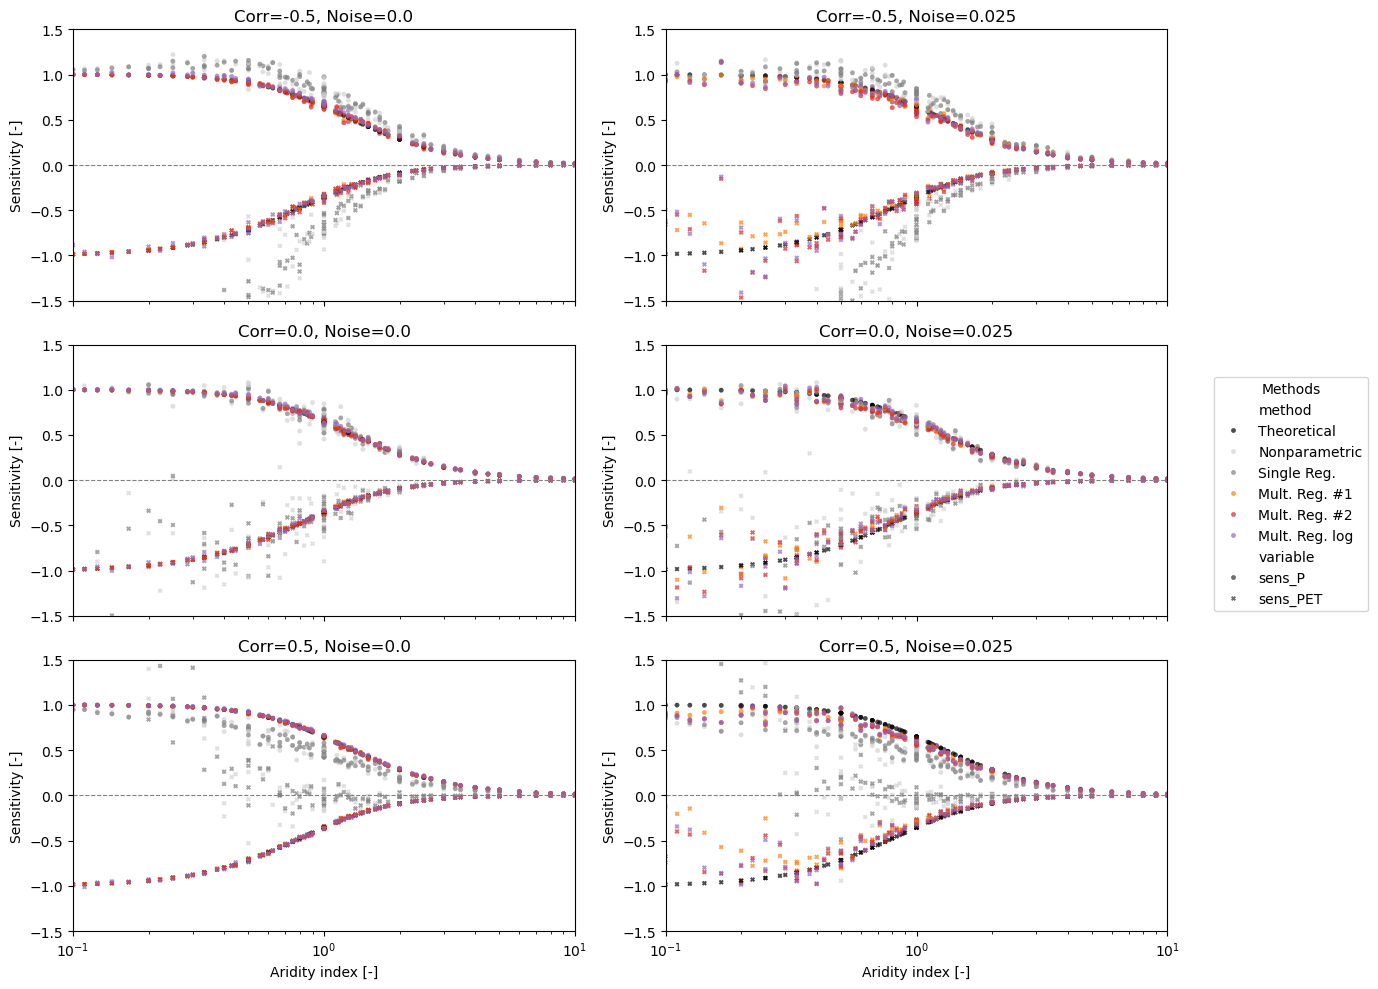

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
import seaborn as sns

# Define functions to calculate streamflow and sensitivities
def calculate_streamflow(P, PET, n):
    return P - (P**-n + PET**-n)**(-1 / n)

def calculate_sensitivities(P, PET, n):
    dQ_dP = 1 - (1 + (P / PET)**n)**((-1 / n) - 1)
    dQ_dPET = - (1 + (PET / P)**n)**((-1 / n) - 1)
    return dQ_dP, dQ_dPET

# Generate synthetic data based on correlation and noise
def generate_data(p_mean, pet_mean, corr, noise):
    sd_P = 0.1 * p_mean
    sd_PET = 0.1 * pet_mean
    cov_P_PET = corr * sd_P * sd_PET
    sigma = np.array([[sd_P**2, cov_P_PET], [cov_P_PET, sd_PET**2]])
    mu = np.array([p_mean, pet_mean])
    sample = multivariate_normal(mu, sigma).rvs(50)
    df_art = pd.DataFrame(sample, columns=["P", "PET"])
    df_art["Q"] = calculate_streamflow(df_art["P"].values, df_art["PET"].values, 2)

    # Add noise if specified
    if noise > 0:
        df_art["Q"] *= (1 + np.random.normal(0, noise, len(df_art)))
        df_art["P"] *= (1 + np.random.normal(0, noise, len(df_art)))
        df_art["PET"] *= (1 + np.random.normal(0, noise, len(df_art)))
    
    # Calculate streamflow
    
    return df_art

# Main plotting function
def plot_sensitivities():
    # Define parameter ranges and settings
    p_means = np.linspace(200, 2000, 10)  # P values
    pet_means = np.linspace(200, 2000, 10)  # PET values
    correlations = [-0.5, 0.0, 0.5]  # Correlation values
    noise_levels = [0.0, 0.025]  # 95% will lie within two standard deviations (±2*X%) of the mean.

    
    fig, axs = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
    
    for j, noise in enumerate(noise_levels):  # Columns: Noise levels
        for i, corr in enumerate(correlations):  # Rows: Different correlations
            results = []
            
            for p_mean in p_means:
                for pet_mean in pet_means:
                    # Generate data
                    df_art = generate_data(p_mean=p_mean, pet_mean=pet_mean, corr=corr, noise=noise)
                    
                    # Calculate theoretical sensitivities
                    sens_P_theory, sens_PET_theory = calculate_sensitivities(p_mean, pet_mean, n=2)
                    
                    # Calculate aridity index (PET/P)
                    aridity_index = pet_mean / p_mean
                    
                    # Method 1: Nonparametric estimation (median of ratios)
                    sens_P_method1 = np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["P"] - df_art["P"].mean()))
                    sens_PET_method1 = np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["PET"] - df_art["PET"].mean()))
                    
                    # Method 2: Single regressions (independent variables separately)
                    model_P_Q = LinearRegression(fit_intercept=True).fit(df_art[['P']], df_art['Q'])
                    model_PET_Q = LinearRegression(fit_intercept=True).fit(df_art[['PET']], df_art['Q'])
                    sens_P_method2 = model_P_Q.coef_[0]
                    sens_PET_method2 = model_PET_Q.coef_[0]
                    
                    # Method 3: Multiple regression (non-centered data)
                    X_noncentered = df_art[["P", "PET"]]
                    y_noncentered = df_art["Q"]
                    sens_P_method3, sens_PET_method3 = LinearRegression(fit_intercept=False).fit(X_noncentered, y_noncentered).coef_
                    
                    # Method 4: Multiple regression (centered data)
                    X_centered = X_noncentered - X_noncentered.mean()
                    y_centered = y_noncentered - y_noncentered.mean()
                    sens_P_method4, sens_PET_method4 = LinearRegression(fit_intercept=False).fit(X_centered, y_centered).coef_
                    
                    # Method 5: Log-log regression (elasticities converted to sensitivities)
                    log_X = np.log(df_art[["P", "PET"]])
                    log_y = np.log(df_art["Q"])
                    log_model = LinearRegression(fit_intercept=True).fit(log_X, log_y)
                    sens_P_method5 = log_model.coef_[0] * df_art["Q"].mean() / df_art["P"].mean()
                    sens_PET_method5 = log_model.coef_[1] * df_art["Q"].mean() / df_art["PET"].mean()

                    """
                    # Method 6: Multi-year averaging
                    n_years = 10
                    data_avg = pd.DataFrame({"Q": y_noncentered,
                                             "P": X_noncentered['P'],
                                             "PET": X_noncentered['PET']})
                    data_avg["Q"] = data_avg["Q"].rolling(window=n_years).mean()
                    data_avg["P"] = data_avg["P"].rolling(window=n_years).mean()
                    data_avg["PET"] = data_avg["PET"].rolling(window=n_years).mean()
                    averaged_data = data_avg.dropna()
                    
                    if not averaged_data.empty:
                        avg_model = LinearRegression(fit_intercept=True).fit(averaged_data[["P", "PET"]], averaged_data["Q"])
                        sens_P_method6 = avg_model.coef_[0]
                        sens_PET_method6 = avg_model.coef_[1]
                    """

                    # Append results for all methods and theoretical values
                    results.extend([
                        {"aridity_index": aridity_index,
                         "method": "Theoretical", "sens_P": sens_P_theory,
                         "sens_PET": sens_PET_theory},
                        {"aridity_index": aridity_index,
                         "method": "Nonparametric", "sens_P": sens_P_method1,
                         "sens_PET": sens_PET_method1},
                        {"aridity_index": aridity_index,
                         "method": "Single Reg.", "sens_P": sens_P_method2,
                         "sens_PET": sens_PET_method2},
                        {"aridity_index": aridity_index,
                         "method": "Mult. Reg. #1",
                         "sens_P": sens_P_method3,
                         "sens_PET": sens_PET_method3},
                        {"aridity_index": aridity_index,
                         "method": "Mult. Reg. #2",
                         "sens_P": sens_P_method4,
                         "sens_PET": sens_PET_method4},
                        {"aridity_index": aridity_index,
                         "method": "Mult. Reg. log",
                         "sens_P": sens_P_method5,
                         "sens_PET": sens_PET_method5}
                        ])
                        #,
                        #    {"aridity_index": aridity_index,
                        #     "method": "Averaging",
                        #     "sens_P": sens_P_method6,
                        #     "sens_PET": sens_PET_method6}
                        
            # Define custom colors for each method
            custom_palette = {
                'Theoretical': 'black',
                'Nonparametric': 'lightgrey',
                'Single Reg.': 'grey',
                'Mult. Reg. #1': 'tab:orange',
                'Mult. Reg. #2': 'tab:red',
                'Mult. Reg. log': 'tab:purple',
                'Averaging': 'tab:blue'
            }
            
            # Convert results to DataFrame for plotting
            results_df = pd.DataFrame(results)
            results_melted = results_df.melt(
                id_vars=["aridity_index", "method"],
                value_vars=["sens_P", "sens_PET"],
                var_name="variable",
                value_name="sensitivity"
            )
            
            # Plot sensitivities vs aridity index for each method and variable
            ax = axs[i][j]

            # Plot sensitivities vs aridity index for each method and variable
            '''
            sns.lineplot(
                data=results_melted,
                x="aridity_index", 
                y="sensitivity", 
                hue="method", 
                style="variable",
                ax=ax,
                palette=custom_palette #'tab10'  
            )
            '''
            sns.scatterplot(
                data=results_melted,
                x="aridity_index", 
                y="sensitivity", 
                hue="method", 
                style="variable",
                ax=ax,
                palette=custom_palette,  
                alpha=0.7,              
                s=10,                    
                edgecolor=None         
            )
            ax.legend().remove()
            ax.set_title(f"Corr={corr}, Noise={noise}")
            ax.set_xlabel("Aridity index [-]")
            ax.set_ylabel("Sensitivity [-]")
            ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
            ax.set_xscale("log")
            ax.set_xlim(0.1, 10)
            ax.set_ylim(-1.5, 1.5)

    # Create a single legend outside all subplots
    handles, labels = axs[0][0].get_legend_handles_labels()  # Get handles and labels from one of the subplots
    fig.legend(handles, labels, loc="center right", title="Methods", bbox_to_anchor=(1.15, 0.5))
    
    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.tight_layout()
    plt.show()

# Call the plotting function to display the figure
plot_sensitivities()

# add bar plots with averaged relative error


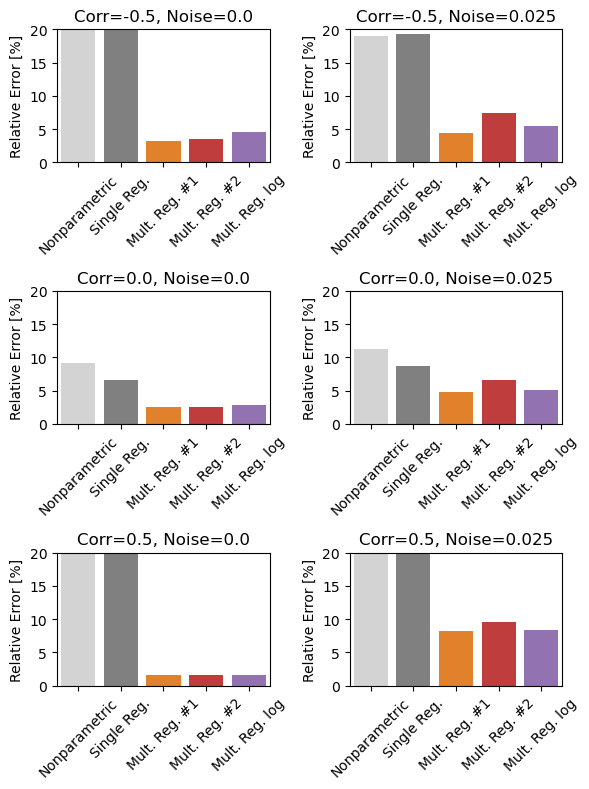

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Define functions to calculate streamflow and sensitivities
def calculate_streamflow(P, PET, n):
    return P - (P**-n + PET**-n)**(-1 / n)

def calculate_sensitivities(P, PET, n):
    dQ_dP = 1 - (1 + (P / PET)**n)**((-1 / n) - 1)
    dQ_dPET = - (1 + (PET / P)**n)**((-1 / n) - 1)
    return dQ_dP, dQ_dPET

# Generate synthetic data based on correlation and noise
def generate_data(p_mean, pet_mean, corr, noise):
    sd_P = 0.1 * p_mean
    sd_PET = 0.1 * pet_mean
    cov_P_PET = corr * sd_P * sd_PET
    sigma = np.array([[sd_P**2, cov_P_PET], [cov_P_PET, sd_PET**2]])
    mu = np.array([p_mean, pet_mean])
    sample = multivariate_normal(mu, sigma).rvs(50)
    df_art = pd.DataFrame(sample, columns=["P", "PET"])
    df_art["Q"] = calculate_streamflow(df_art["P"].values, df_art["PET"].values, 2)

    # Add noise if specified
    if noise > 0:
        df_art["Q"] *= (1 + np.random.normal(0, noise, len(df_art)))
        df_art["P"] *= (1 + np.random.normal(0, noise, len(df_art)))
        df_art["PET"] *= (1 + np.random.normal(0, noise, len(df_art)))
    
    return df_art

# Function to calculate relative error
def calculate_relative_error(estimated, theoretical):
    return 100*np.abs((estimated - theoretical) / theoretical)

# Main plotting function for average relative errors
def plot_average_relative_errors():
    # Define parameter ranges and settings
    p_means = np.linspace(200, 2000, 50)  # P values
    pet_means = np.linspace(200, 2000, 50)  # PET values
    correlations = [-0.5, 0.0, 0.5]  # Correlation values
    noise_levels = [0.0, 0.025]  # 95% will lie within two standard deviations (±2*X%) of the mean.
    
    fig, axs = plt.subplots(3, 2, figsize=(6, 8))  # Create a grid for bar plots
    
    for j, noise in enumerate(noise_levels):  # Columns: Noise levels
        for i, corr in enumerate(correlations):  # Rows: Different correlations
            relative_errors = {method: [] for method in [
                "Nonparametric", "Single Reg.", "Mult. Reg. #1", 
                "Mult. Reg. #2", "Mult. Reg. log"
            ]}
            
            for p_mean in p_means:
                for pet_mean in pet_means:
                    # Generate data
                    df_art = generate_data(p_mean=p_mean, pet_mean=pet_mean, corr=corr, noise=noise)
                    
                    # Calculate theoretical sensitivities
                    sens_P_theory, sens_PET_theory = calculate_sensitivities(p_mean, pet_mean, n=2)
                    
                    # Method 1: Nonparametric estimation (median of ratios)
                    sens_P_method1 = np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["P"] - df_art["P"].mean()))
                    
                    # Method 2: Single regressions (independent variables separately)
                    model_P_Q = LinearRegression(fit_intercept=True).fit(df_art[['P']], df_art['Q'])
                    sens_P_method2 = model_P_Q.coef_[0]
                    
                    # Method 3: Multiple regression (non-centered data)
                    X_noncentered = df_art[["P", "PET"]]
                    y_noncentered = df_art["Q"]
                    sens_P_method3 = LinearRegression(fit_intercept=False).fit(X_noncentered, y_noncentered).coef_[0]
                    
                    # Method 4: Multiple regression (centered data)
                    X_centered = X_noncentered - X_noncentered.mean()
                    y_centered = y_noncentered - y_noncentered.mean()
                    sens_P_method4 = LinearRegression(fit_intercept=False).fit(X_centered, y_centered).coef_[0]
                    
                    # Method 5: Log-log regression (elasticities converted to sensitivities)
                    log_X = np.log(df_art[["P", "PET"]])
                    log_y = np.log(df_art["Q"])
                    log_model = LinearRegression(fit_intercept=True).fit(log_X, log_y)
                    sens_P_method5 = log_model.coef_[0] * df_art["Q"].mean() / df_art["P"].mean()
                    
                    # Calculate relative errors and store them
                    relative_errors["Nonparametric"].append(calculate_relative_error(sens_P_method1, sens_P_theory))
                    relative_errors["Single Reg."].append(calculate_relative_error(sens_P_method2, sens_P_theory))
                    relative_errors["Mult. Reg. #1"].append(calculate_relative_error(sens_P_method3, sens_P_theory))
                    relative_errors["Mult. Reg. #2"].append(calculate_relative_error(sens_P_method4, sens_P_theory))
                    relative_errors["Mult. Reg. log"].append(calculate_relative_error(sens_P_method5, sens_P_theory))
            
            # Average relative errors for each method
            avg_relative_errors = {method: np.mean(errors) for method, errors in relative_errors.items()}
            
            # Define custom colors for each method
            custom_palette = {
                'Theoretical': 'black',
                'Nonparametric': 'lightgrey',
                'Single Reg.': 'grey',
                'Mult. Reg. #1': 'tab:orange',
                'Mult. Reg. #2': 'tab:red',
                'Mult. Reg. log': 'tab:purple',
                'Averaging': 'tab:blue'
            }
            
            # Plot bar plot of average relative errors
            ax = axs[i][j]
            sns.barplot(
                x=list(avg_relative_errors.keys()), 
                y=list(avg_relative_errors.values()), 
                ax=ax,
                palette=custom_palette
            )
            ax.set_title(f"Corr={corr}, Noise={noise}")
            ax.set_ylabel("Relative Error [%]")
            #ax.set_xlabel("Method")
            ax.tick_params(axis='x', rotation=45)
            ax.set_ylim(0,20)
    
    # Finalize layout and show the figure
    plt.tight_layout()
    plt.show()

# Call the plotting function to display the figure with average relative errors
plot_average_relative_errors()


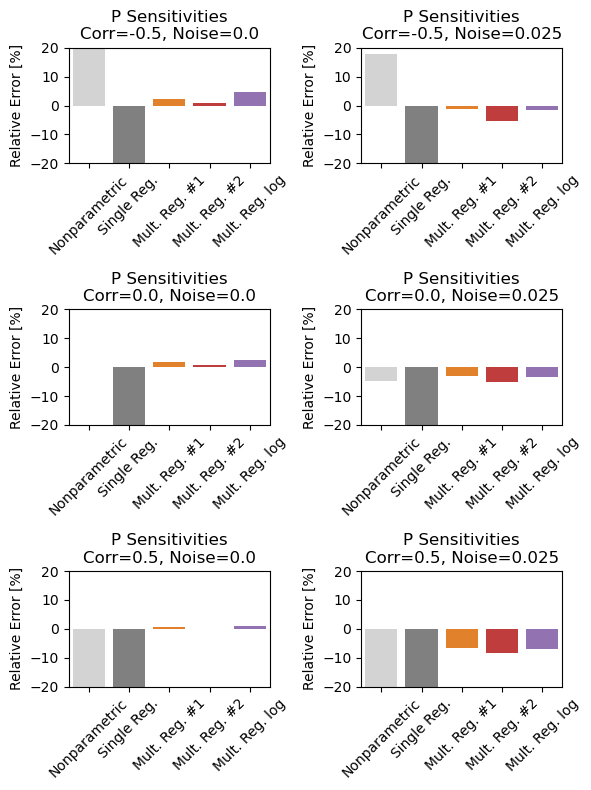

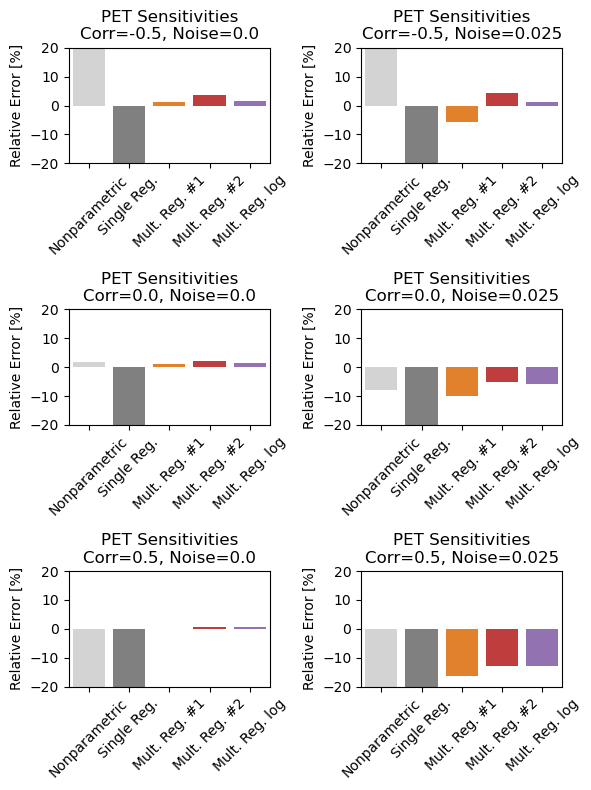

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Define functions to calculate streamflow and sensitivities
def calculate_streamflow(P, PET, n):
    return P - (P**-n + PET**-n)**(-1 / n)

def calculate_sensitivities(P, PET, n):
    dQ_dP = 1 - (1 + (P / PET)**n)**((-1 / n) - 1)
    dQ_dPET = - (1 + (PET / P)**n)**((-1 / n) - 1)
    return dQ_dP, dQ_dPET

# Generate synthetic data based on correlation and noise
def generate_data(p_mean, pet_mean, corr, noise):
    sd_P = 0.1 * p_mean
    sd_PET = 0.1 * pet_mean
    cov_P_PET = corr * sd_P * sd_PET
    sigma = np.array([[sd_P**2, cov_P_PET], [cov_P_PET, sd_PET**2]])
    mu = np.array([p_mean, pet_mean])
    sample = multivariate_normal(mu, sigma).rvs(50)
    df_art = pd.DataFrame(sample, columns=["P", "PET"])
    df_art["Q"] = calculate_streamflow(df_art["P"].values, df_art["PET"].values, 2)

    # Add noise if specified
    if noise > 0:
        df_art["Q"] *= (1 + np.random.normal(0, noise, len(df_art)))
        df_art["P"] *= (1 + np.random.normal(0, noise, len(df_art)))
        df_art["PET"] *= (1 + np.random.normal(0, noise, len(df_art)))
    
    return df_art

# Function to calculate relative error
def calculate_relative_error(estimated, theoretical):
    return 100 * ((estimated - theoretical) / theoretical)

# Main plotting function for average relative errors
def plot_average_relative_errors():
    # Define parameter ranges and settings
    p_means = np.linspace(200, 2000, 10)  # P values
    pet_means = np.linspace(200, 2000, 10)  # PET values
    correlations = [-0.5, 0.0, 0.5]  # Correlation values
    noise_levels = [0.0, 0.025]  # Noise levels
    
    fig_P, axs_P = plt.subplots(3, 2, figsize=(6, 8))  # For P sensitivities
    fig_PET, axs_PET = plt.subplots(3, 2, figsize=(6, 8))  # For PET sensitivities
    
    for j, noise in enumerate(noise_levels):  # Columns: Noise levels
        for i, corr in enumerate(correlations):  # Rows: Different correlations
            
            relative_errors_P = {method: [] for method in [
                "Nonparametric", "Single Reg.", "Mult. Reg. #1", 
                "Mult. Reg. #2", "Mult. Reg. log"
            ]}
            relative_errors_PET = {method: [] for method in [
                "Nonparametric", "Single Reg.", "Mult. Reg. #1", 
                "Mult. Reg. #2", "Mult. Reg. log"
            ]}
            
            for p_mean in p_means:
                for pet_mean in pet_means:
                    # Generate data
                    df_art = generate_data(p_mean=p_mean, pet_mean=pet_mean, corr=corr, noise=noise)
                    
                    # Calculate theoretical sensitivities
                    sens_P_theory, sens_PET_theory = calculate_sensitivities(p_mean, pet_mean, n=2)
                    
                    # Method 1: Nonparametric estimation (median of ratios)
                    sens_P_method1 = np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["P"] - df_art["P"].mean()))
                    sens_PET_method1 = np.median((df_art["Q"] - df_art["Q"].mean()) / (df_art["PET"] - df_art["PET"].mean()))
                    
                    # Method 2: Single regressions (independent variables separately)
                    model_P_Q = LinearRegression(fit_intercept=False).fit(df_art[['P']], df_art['Q'])
                    model_PET_Q = LinearRegression(fit_intercept=False).fit(df_art[['PET']], df_art['Q'])
                    sens_P_method2 = model_P_Q.coef_[0]
                    sens_PET_method2 = model_PET_Q.coef_[0]
                    
                    # Method 3: Multiple regression (non-centered data)
                    X_noncentered = df_art[["P", "PET"]]
                    y_noncentered = df_art["Q"]
                    coefs_noncentered = LinearRegression(fit_intercept=False).fit(X_noncentered, y_noncentered).coef_
                    sens_P_method3 = coefs_noncentered[0]
                    sens_PET_method3 = coefs_noncentered[1]
                    
                    # Method 4: Multiple regression (centered data)
                    X_centered = X_noncentered - X_noncentered.mean()
                    y_centered = y_noncentered - y_noncentered.mean()
                    coefs_centered = LinearRegression(fit_intercept=False).fit(X_centered, y_centered).coef_
                    sens_P_method4 = coefs_centered[0]
                    sens_PET_method4 = coefs_centered[1]
                    
                    # Method 5: Log-log regression (elasticities converted to sensitivities)
                    log_X = np.log(df_art[["P", "PET"]])
                    log_y = np.log(df_art["Q"])
                    log_model = LinearRegression(fit_intercept=True).fit(log_X, log_y)
                    sens_P_method5 = log_model.coef_[0] * df_art["Q"].mean() / df_art["P"].mean()
                    sens_PET_method5 = log_model.coef_[1] * df_art["Q"].mean() / df_art["PET"].mean()
                    
                    # Calculate relative errors and store them for P and PET sensitivities
                    relative_errors_P["Nonparametric"].append(calculate_relative_error(sens_P_method1, sens_P_theory))
                    relative_errors_P["Single Reg."].append(calculate_relative_error(sens_P_method2, sens_P_theory))
                    relative_errors_P["Mult. Reg. #1"].append(calculate_relative_error(sens_P_method3, sens_P_theory))
                    relative_errors_P["Mult. Reg. #2"].append(calculate_relative_error(sens_P_method4, sens_P_theory))
                    relative_errors_P["Mult. Reg. log"].append(calculate_relative_error(sens_P_method5, sens_P_theory))
                    
                    relative_errors_PET["Nonparametric"].append(calculate_relative_error(sens_PET_method1, sens_PET_theory))
                    relative_errors_PET["Single Reg."].append(calculate_relative_error(sens_PET_method2, sens_PET_theory))
                    relative_errors_PET["Mult. Reg. #1"].append(calculate_relative_error(sens_PET_method3, sens_PET_theory))
                    relative_errors_PET["Mult. Reg. #2"].append(calculate_relative_error(sens_PET_method4, sens_PET_theory))
                    relative_errors_PET["Mult. Reg. log"].append(calculate_relative_error(sens_PET_method5, sens_PET_theory))
            
            # Average relative errors for each method
            avg_relative_errors_P = {method: np.mean(errors) for method, errors in relative_errors_P.items()}
            avg_relative_errors_PET = {method: np.mean(errors) for method, errors in relative_errors_PET.items()}

            custom_palette = {
                'Theoretical': 'black',
                'Nonparametric': 'lightgrey',
                'Single Reg.': 'grey',
                'Mult. Reg. #1': 'tab:orange',
                'Mult. Reg. #2': 'tab:red',
                'Mult. Reg. log': 'tab:purple',
                'Averaging': 'tab:blue'
            }

            
            # Plot bar plot of average relative errors for P sensitivities
            ax_p = axs_P[i][j]
            sns.barplot(
                x=list(avg_relative_errors_P.keys()), 
                y=list(avg_relative_errors_P.values()), 
                ax=ax_p,
                palette=custom_palette#"viridis"
            )
            ax_p.set_title(f"P Sensitivities\nCorr={corr}, Noise={noise}")
            ax_p.set_ylabel("Relative Error [%]")
            ax_p.tick_params(axis='x', rotation=45)
            ax_p.set_ylim(-20, 20)
            
            # Plot bar plot of average relative errors for PET sensitivities
            ax_pet = axs_PET[i][j]
            sns.barplot(
                x=list(avg_relative_errors_PET.keys()), 
                y=list(avg_relative_errors_PET.values()), 
                ax=ax_pet,
                palette=custom_palette#"viridis"
            )
            ax_pet.set_title(f"PET Sensitivities\nCorr={corr}, Noise={noise}")
            ax_pet.set_ylabel("Relative Error [%]")
            ax_pet.tick_params(axis='x', rotation=45)
            ax_pet.set_ylim(-20, 20)
    
    # Finalize layout and show the figures
    fig_P.tight_layout()
    fig_PET.tight_layout()
    plt.show()

plot_average_relative_errors()

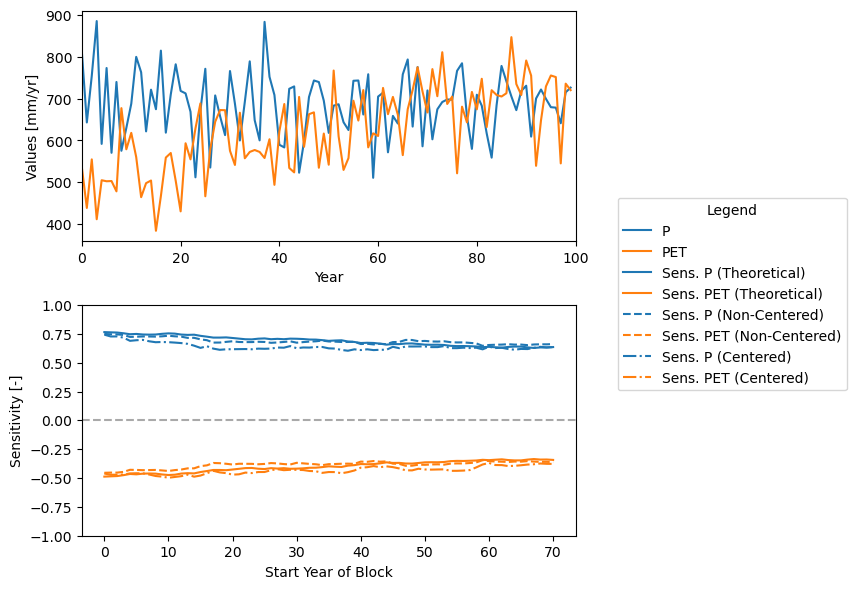

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Define functions to calculate streamflow and sensitivities
def calculate_streamflow(P, PET, n):
    return P - (P**-n + PET**-n)**(-1 / n)

def calculate_sensitivities(P, PET, n):
    dQ_dP = 1 - (1 + (P / PET)**n)**((-1 / n) - 1)
    dQ_dPET = - (1 + (PET / P)**n)**((-1 / n) - 1)
    return dQ_dP, dQ_dPET

# Generate correlated random series with trends
np.random.seed(123)
years = np.arange(100)  # 100 years

# Set correlation and noise level
corr = -0.33  # Correlation between P and PET
noise = 0.025  # Noise level

# Generate correlated P and PET time series
mean_P, mean_PET = 700, 500
sd_P, sd_PET = 75, 50
cov_P_PET = corr * sd_P * sd_PET  # Covariance between P and PET
sigma = np.array([[sd_P**2, cov_P_PET], [cov_P_PET, sd_PET**2]])  # Covariance matrix
mu = np.array([mean_P, mean_PET])  # Mean values for P and PET

# Generate correlated samples for P and PET with trends
trend_P = 0.0
trend_PET = 0.5
samples = multivariate_normal(mu, sigma).rvs(len(years))
P = samples[:, 0] * (1 +  trend_P * years / max(years))
PET = samples[:, 1] * (1 +  trend_PET * years / max(years))  # Add trend to PET
Q = calculate_streamflow(P, PET, n=2)

# Add noise to the series
Q *= (1 + np.random.normal(0, noise, len(Q)))
P *= (1 + np.random.normal(0, noise, len(P)))
PET *= (1 + np.random.normal(0, noise, len(PET)))

# Create DataFrame
df = pd.DataFrame({'Year': years, 'P': P, 'PET': PET, 'Q': Q})

# Calculate sensitivities for 30-year moving blocks
block_size = 30
sens_P_theoretical = []
sens_PET_theoretical = []
sens_P_noncentered = []
sens_PET_noncentered = []
sens_P_centered = []
sens_PET_centered = []

for start in range(len(years) - block_size + 1):
    block = df.iloc[start:start + block_size]
    
    # Theoretical sensitivities based on mean P and PET in the block
    mean_P_block = block['P'].mean()
    mean_PET_block = block['PET'].mean()
    sens_P, sens_PET = calculate_sensitivities(mean_P_block, mean_PET_block, n=2)
    sens_P_theoretical.append(sens_P)
    sens_PET_theoretical.append(sens_PET)
    
    # Method: Non-centered multiple regression
    X_noncentered = block[["P", "PET"]]
    y_noncentered = block["Q"]
    model_noncentered = LinearRegression(fit_intercept=False).fit(X_noncentered, y_noncentered)
    sens_P_nc, sens_PET_nc = model_noncentered.coef_
    sens_P_noncentered.append(sens_P_nc)
    sens_PET_noncentered.append(sens_PET_nc)
    
    # Method: Centered multiple regression
    X_centered = X_noncentered - X_noncentered.mean()
    y_centered = y_noncentered - y_noncentered.mean()
    model_centered = LinearRegression(fit_intercept=False).fit(X_centered, y_centered)
    sens_P_c, sens_PET_c = model_centered.coef_
    sens_P_centered.append(sens_P_c)
    sens_PET_centered.append(sens_PET_c)

# Create DataFrame for sensitivities
df_sens = pd.DataFrame({
    'Start_Year': years[:len(sens_P_theoretical)],
    'Sens_P_Theoretical': sens_P_theoretical,
    'Sens_PET_Theoretical': sens_PET_theoretical,
    'Sens_P_NonCentered': sens_P_noncentered,
    'Sens_PET_NonCentered': sens_PET_noncentered,
    'Sens_P_Centered': sens_P_centered,
    'Sens_PET_Centered': sens_PET_centered
})

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

# Plot P and PET trends
axs[0].plot(df['Year'], df['P'], label='P', color='tab:blue')
axs[0].plot(df['Year'], df['PET'], label='PET', color='tab:orange')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Values [mm/yr]')
axs[0].set_xlim(0, 100)

# Plot sensitivities (theoretical vs non-centered and centered methods)
axs[1].plot(df_sens['Start_Year'], df_sens['Sens_P_Theoretical'], label='Sens. P (Theoretical)', color='tab:blue', linestyle='-')
axs[1].plot(df_sens['Start_Year'], df_sens['Sens_PET_Theoretical'], label='Sens. PET (Theoretical)', color='tab:orange', linestyle='-')
axs[1].plot(df_sens['Start_Year'], df_sens['Sens_P_NonCentered'], label='Sens. P (Non-Centered)', color='tab:blue', linestyle='--')
axs[1].plot(df_sens['Start_Year'], df_sens['Sens_PET_NonCentered'], label='Sens. PET (Non-Centered)', color='tab:orange', linestyle='--')
axs[1].plot(df_sens['Start_Year'], df_sens['Sens_P_Centered'], label='Sens. P (Centered)', color='tab:blue', linestyle='-.')
axs[1].plot(df_sens['Start_Year'], df_sens['Sens_PET_Centered'], label='Sens. PET (Centered)', color='tab:orange', linestyle='-.')
axs[1].axhline(0, color='darkgrey', linestyle='--')
axs[1].set_xlabel('Start Year of Block')
axs[1].set_ylabel('Sensitivity [-]')
axs[1].set_ylim(-1, 1)

# Move legend outside the plots
handles_0, labels_0 = axs[0].get_legend_handles_labels()
handles_1, labels_1 = axs[1].get_legend_handles_labels()

fig.legend(handles_0 + handles_1, labels_0 + labels_1,
           loc="center right", bbox_to_anchor=(0.85, 0.5), title="Legend")

plt.tight_layout(rect=[0, 0, 0.6, 1])  # Adjust layout to make space for the legend
plt.show()
